# Does listing the salary reduce the GPG?

Let's look at whether companies that list salaries in their job ads have smaller gender pay gaps. Later we'll also filter just for senior positions.

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Get indeed data

In [38]:
# To get txt data in dataframe
import json
from pandas.io.json import json_normalize #package for flattening json in pandas df

def txt_to_df(txt_file_loc):
    txt =  open(txt_file_loc,"r").read()
    txt = json.loads(txt)
    df = json_normalize(txt['results'])
    return df

fulltime_df = txt_to_df("indeed_job_search_api/job_ad_fulltime_with_summary.txt")
parttime_df = txt_to_df("indeed_job_search_api/job_ad_parttime_with_summary.txt")

## Get salary listing data

In [39]:
def salaryDf(filename):
    with open(filename, 'r') as fp:
        salaryListing = json.load(fp)
    salaryListing = pd.DataFrame.from_dict(salaryListing, orient='index')
    salaryListing.columns = ['salaryInfo']
    salaryListing.index = salaryListing.index.map(np.int32)
    salaryListing["containsSalary"] = salaryListing.salaryInfo.str.contains('£')
    salaryListing["containsSalaryBand"] = salaryListing.salaryInfo.str.count('£')==2
    return salaryListing

In [40]:
fulltimeSalary = salaryDf("selectSalaryListingFullTime.json")
parttimeSalary = salaryDf("selectSalaryListingPartTime.json")

## Figure out if the salary listing data contains the actual salary

In [41]:
def getContainsSalary(df, salary):
    salary_df = df.merge(salary, 'left', left_index=True, right_index=True)
    salary_df[['containsSalary', 'containsSalaryBand']] = salary_df[['containsSalary', 'containsSalaryBand']].fillna(value=False)
    return salary_df

## Combine datasets

In [42]:
fulltime_df = getContainsSalary(fulltime_df, fulltimeSalary)
parttime_df = getContainsSalary(parttime_df, parttimeSalary)
df = pd.concat([fulltime_df,parttime_df]) # text files from with job summary

## Get Government Gender Pay Gap Data

In [43]:
pay_df = pd.read_csv('UK Gender Pay Gap Data - 2017 to 2018.csv')

## Join the indeed and government data using a custom name matcher file

In [60]:
pay_df.EmployerName = pay_df.EmployerName.str.lower()

In [53]:
df.company = df.company.str.lower()

In [34]:
companyMapper = pd.read_csv("Indeed to GPG Company Name - indeed_companies_match.csv", na_values='no match', \
            usecols=['Indeed Company', 'Human-Verified GPG Match'])

In [55]:
df = df.merge(companyMapper, how='left', left_on='company', right_on='Indeed Company')

In [62]:
fullData = df.merge(pay_df, how='left', left_on='Human-Verified GPG Match', right_on='EmployerName')

## Generic plotting function

In [240]:
def plotComparison(x_col, titlePrefix, data):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    y_col = 'DiffMeanHourlyPercent'
    results = smf.ols(y_col +'~' + x_col, data=data).fit()
    InterceptStd = np.sqrt(results.cov_params()["Intercept"]["Intercept"])
    ContainsSalaryStd = np.sqrt(results.cov_params()[x_col][x_col])
    print(y_col, 'Intercept', results.params['Intercept'], "±",InterceptStd)
    print(y_col, x_col, results.params[x_col], "±",ContainsSalaryStd)

    label = x_col + "  " + str(round(results.params[x_col], 3)) + "±" + str(round(ContainsSalaryStd,3))
    x_pred = [0,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    dataDict = {x_col:x_pred}
    y_pred = results.predict(exog=pd.DataFrame(dataDict)).values
    
    plt.title(titlePrefix + ' vs median GPG', fontsize=15)
    plt.plot(paygapVsSalaryAd[x_col], paygapVsSalaryAd[y_col], 'o', label='data')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.plot(x_pred, y_pred, label=label)
    plt.legend()
    
    plt.subplot(1,2,2)
    y_col = 'DiffMedianHourlyPercent'
    results = smf.ols(y_col +'~' + x_col, data=data).fit()
    InterceptStd = np.sqrt(results.cov_params()["Intercept"]["Intercept"])
    ContainsSalaryStd = np.sqrt(results.cov_params()[x_col][x_col])
    print(y_col, 'Intercept', results.params['Intercept'], "±",InterceptStd)
    print(y_col, x_col, results.params[x_col], "±",ContainsSalaryStd)

    label = x_col + "  " + str(round(results.params[x_col], 3)) + "±" + str(round(ContainsSalaryStd,3))
    
    x_pred = [0,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    data = {x_col:x_pred}
    y_pred = results.predict(exog=pd.DataFrame(data)).values
    
    plt.title(titlePrefix + ' vs median GPG', fontsize=15)
    plt.plot(paygapVsSalaryAd[x_col], paygapVsSalaryAd[y_col], 'o', label='data')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.plot(x_pred, y_pred, label=label)
    plt.legend()

## ad contains salary vs GPG

In [ ]:
paygapVsSalaryAd = fullData.groupby('EmployerName')[['DiffMeanHourlyPercent', 'DiffMedianHourlyPercent', 'containsSalary', 'containsSalaryBand']].mean()

DiffMeanHourlyPercent Intercept 15.8325562409 ± 0.900635070429
DiffMeanHourlyPercent containsSalary 3.08177653755 ± 2.05441736153
DiffMedianHourlyPercent Intercept 11.1426242595 ± 0.864833517333
DiffMedianHourlyPercent containsSalary -3.31629864635 ± 1.97275128538


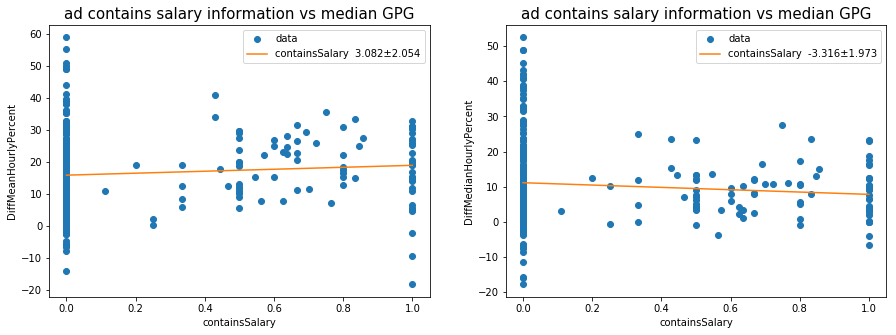

In [247]:
plotComparison('containsSalary','ad contains salary information', paygapVsSalaryAd)

From this we conclude that there is no statistically significant link between whether a companies ads contain salary information and whether it has a good or bad GPG.

## Let's just look at senior leadership positions

### Define leadership role as the job title containing the phrase 'executive', 'manager', 'lead', 'head' or 'chief'

In [259]:
leadership = fullData[(fullData.jobtitle.str.lower().str.contains('executive') | fullData.jobtitle.str.lower().str.contains('manager') \
| fullData.jobtitle.str.lower().str.contains('lead') | fullData.jobtitle.str.lower().str.contains('head') \
         | fullData.jobtitle.str.lower().str.contains('chief'))]

In [260]:
leadershippaygapVsSalaryAd = leadership.groupby('EmployerName')[['DiffMeanHourlyPercent', 'DiffMedianHourlyPercent', 'containsSalary', 'containsSalaryBand']].mean()

DiffMeanHourlyPercent Intercept 19.9422304906 ± 2.26872684542
DiffMeanHourlyPercent containsSalary -3.88222853226 ± 3.76860143916
DiffMedianHourlyPercent Intercept 13.4923430921 ± 1.77306832835
DiffMedianHourlyPercent containsSalary -7.25205130716 ± 2.94525886509


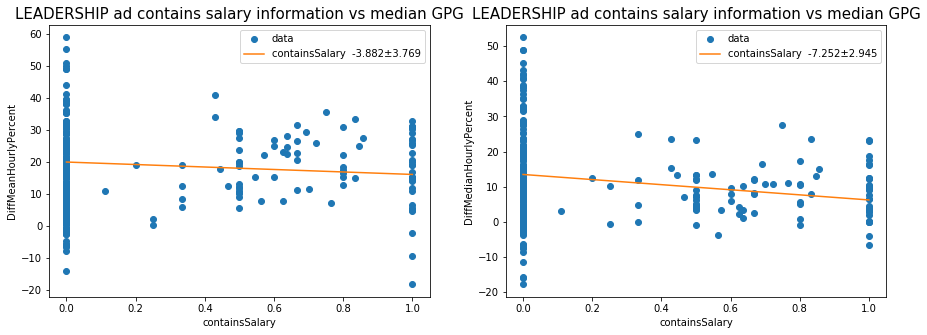

In [263]:
plotComparison('containsSalary', 'LEADERSHIP ad contains salary information', leadershippaygapVsSalaryAd)

Here we see that there is a statistically significant relationship between ads for senior positions and the median gender pay gap. On average a company that always includes salary information will have a GPG that roughly half that of companies that never include salary information in their ads.

## Further work

Here we are looking at median salary for the whole workforce and comparing it to job ads for more senior positions. Future work would look at the median (or mean) for the top quartile of earners.